In [1]:
import torch
import numpy as np
from torch import nn, optim
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
from pathlib import Path
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
!unzip -q /content/gdrive/My\ Drive/data_dogs.zip -d train

In [3]:
import torchvision

In [4]:
transform = transforms.Compose([
            transforms.Resize(size=(299,299)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

images = torchvision.datasets.ImageFolder(root='/content/train/data/train', transform=transform)

In [5]:
class_names = images.classes
len(class_names)

50

In [6]:
img, label = images[0][0], images[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-0.5767, -0.4739, -0.4054,  ..., -1.4500, -1.4500, -1.4672],
         [-0.5767, -0.4568, -0.4397,  ..., -1.3815, -1.3987, -1.4158],
         [-0.6452, -0.4739, -0.4568,  ..., -1.3473, -1.3644, -1.3815],
         ...,
         [ 0.2282,  0.3994,  0.5193,  ..., -1.9638, -1.9295, -1.8782],
         [ 0.2796,  0.4508,  0.6221,  ..., -1.9980, -1.8953, -1.8610],
         [ 0.4166,  0.5364,  0.6734,  ..., -1.9980, -1.8953, -1.8782]],

        [[-0.4251, -0.3375, -0.3025,  ..., -1.2304, -1.1954, -1.2129],
         [-0.4076, -0.3025, -0.3200,  ..., -1.1604, -1.1429, -1.1604],
         [-0.4426, -0.2850, -0.3025,  ..., -1.1078, -1.1078, -1.1253],
         ...,
         [-0.4076, -0.2675, -0.1975,  ..., -1.7556, -1.7206, -1.6681],
         [-0.3901, -0.2675, -0.1450,  ..., -1.7906, -1.7031, -1.6681],
         [-0.3025, -0.2325, -0.1275,  ..., -1.7906, -1.6856, -1.6681]],

        [[ 0.1999,  0.2522,  0.2348,  ..., -0.4101, -0.3927, -0.4101],
         [ 0.2173,  0.2871,  0.

In [6]:
from torch.utils.data import  random_split

In [7]:
train = int(0.8 * len(images))
test = len(images) - train
x_train ,x_test = random_split(images, [train, test])

In [8]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(x_test, batch_size=64, shuffle=False)

In [9]:
for image, label in train_loader:
  print(image.shape, label.shape)
  break

torch.Size([64, 3, 299, 299]) torch.Size([64])


In [10]:
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)

    for i in range(grid_size[0] * grid_size[1]):

        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])

        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)

        # display batch samples with labels
        #sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(label_batch[i].item())
    pass

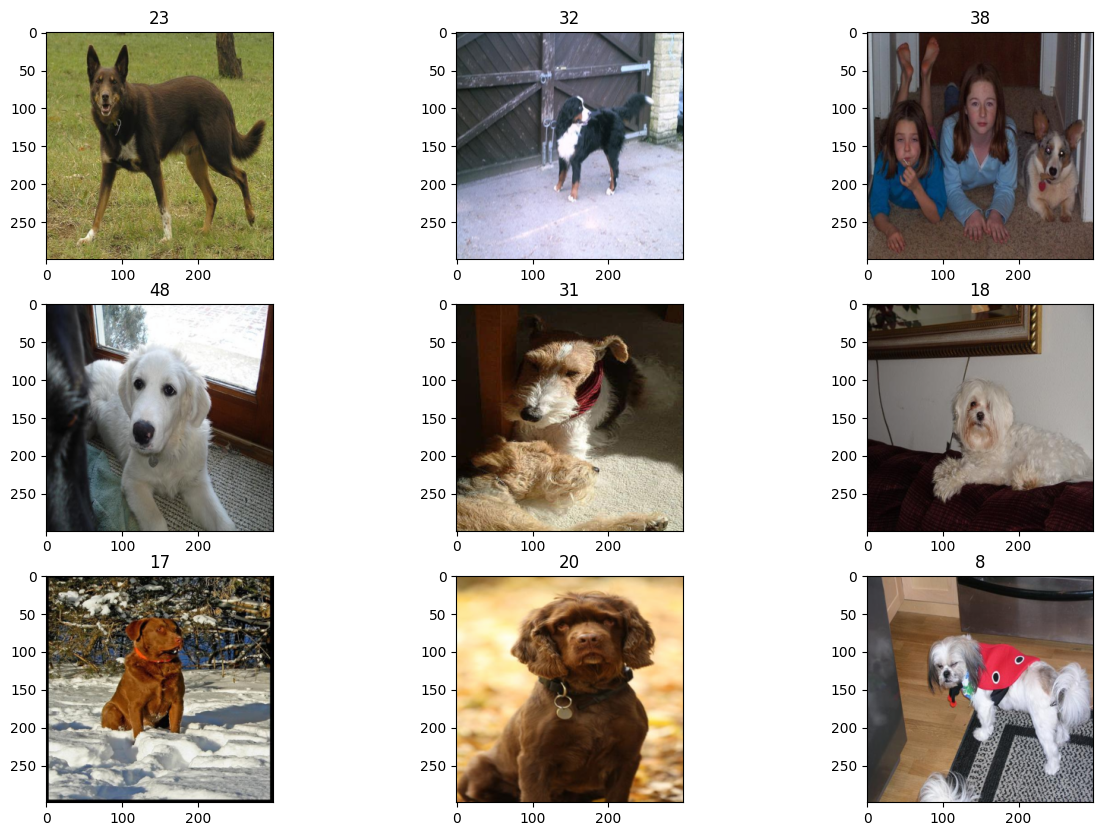

In [11]:
plot_from_batch_generator(train_loader)

In [75]:
import torchvision.models as models

model = models.inception_v3(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Handle the auxilary net
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 50)
# Handle the primary net
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [137]:
model.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.5)

In [88]:
from IPython.display import clear_output

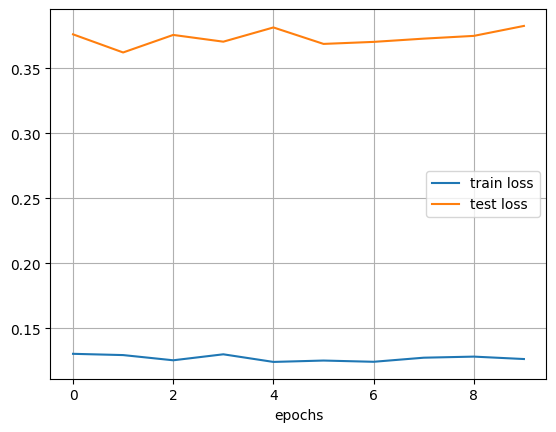

test_acc:  88.91


In [90]:
num_epochs = 10
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model.train()


    for image, labels in train_loader:
        image, labels = image.to(device), labels.to(device)

        opt.zero_grad()
        outs, aux_output = model(image)

        loss = loss_func(outs, labels)
        loss.backward()
        opt.step()
        scheduler.step()

        running_loss += loss.item() * labels.size(0)
        processed_data += labels.size(0)


    loss_epoch =  running_loss / processed_data
    train_loss.append(loss_epoch)

    model.eval()


    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0
        processed_size = 0
        for image, labels in test_loader:
            image, labels = image.to(device), labels.to(device)

            outs = model(image)
            loss = loss_func(outs, labels)

            running_loss += loss.item() * labels.size(0)
            running_corrects += torch.sum(outs.argmax(dim=1) == labels.data).item()
            processed_size += labels.size(0)


    test_acc = round(running_corrects*100/processed_size, 2)


    test_loss.append(running_loss / processed_size)


    clear_output(True)

    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.xlabel('epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

    print('test_acc: ', test_acc)

Проблема в том, что тестовая выборка достаточно мала - порядка 150 картинок на класс. Применим аугментацию данных, чтобы расширить тренировочный датасет

In [128]:
train_val_files = sorted(list(Path('/content/train/data/train').rglob('*.jpeg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [124]:
from collections import Counter
how_much_dogs = dict(Counter([x for x in train_val_labels]))
#посмотрим еще раз на количество собак каждого класса
values  = pd.DataFrame(data = how_much_dogs.values(), index=how_much_dogs.keys(), columns=['amount'])
values

,amount
0,151
1,126
10,129
11,139
12,123
13,137
14,153
15,142
16,174
17,143


In [125]:
#добавим столбец plus - сколько картинок надо добавить, чтобы их было хотя бы по 300 в каждом классе
values['plus'] = (300 - values['amount']).astype(int)
values

,amount,plus
0,151,149
1,126,174
10,129,171
11,139,161
12,123,177
13,137,163
14,153,147
15,142,158
16,174,126
17,143,157


In [127]:
plus_pictures = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(624),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(-45, 45)),
       ])
}

import random

#добавляю здесь новые картинки к сету
for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = Image.open(image_path)

    if values.loc[str(character)]['plus'] <= 0:

        continue

    iter_size = values.loc[character]['plus']
    values.loc[character]['plus'] -= iter_size

    for i in range(int(iter_size)):
        augmenter = random.choice(list(plus_pictures.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpeg")

100%|██████████| 7166/7166 [01:23<00:00, 85.34it/s]


In [146]:
#по новой сделаю DataLoaders
train_val_files = sorted(list(Path('/content/train/data/train').rglob('*.jpeg')))
train_val_labels = [path.parent.name for path in train_val_files]
images2 = torchvision.datasets.ImageFolder(root='/content/train/data/train', transform=transform)

train = int(0.8 * len(images2))
test = len(images2) - train
x_train2 ,x_test2 = random_split(images2, [train, test])
train_loader = torch.utils.data.DataLoader(x_train2, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(x_test2, batch_size=64, shuffle=False)

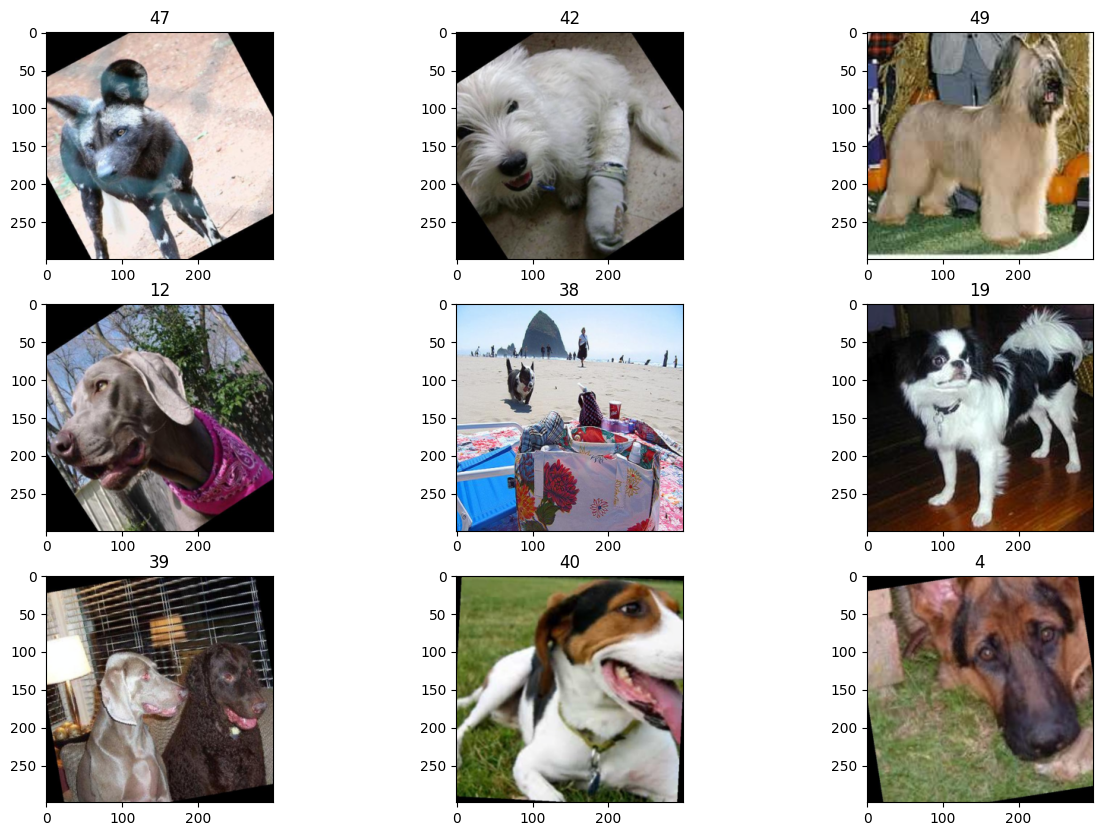

In [149]:
plot_from_batch_generator(train_loader)

In [141]:
model2 = models.inception_v3(pretrained=True)
for param in model2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Handle the auxilary net
num_ftrs = model2.AuxLogits.fc.in_features
model2.AuxLogits.fc = nn.Linear(num_ftrs, 50)
# Handle the primary net
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [143]:
model2.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model2.parameters())


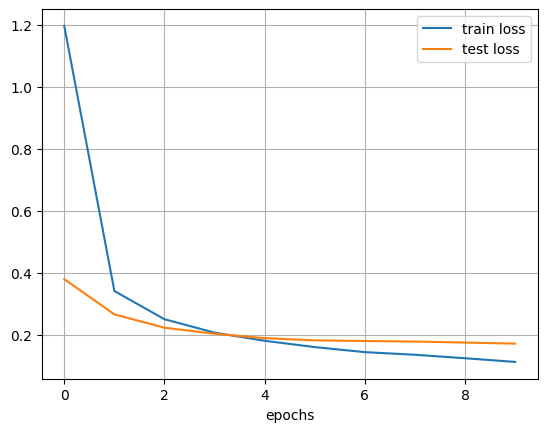

test_acc:  95.4


In [144]:
num_epochs = 10
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model2.train()


    for image, labels in train_loader:
        image, labels = image.to(device), labels.to(device)

        opt.zero_grad()
        outs, _ = model2(image)

        loss = loss_func(outs, labels)
        loss.backward()
        opt.step()


        running_loss += loss.item() * labels.size(0)
        processed_data += labels.size(0)


    loss_epoch =  running_loss / processed_data
    train_loss.append(loss_epoch)

    model2.eval()


    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0
        processed_size = 0
        for image, labels in test_loader:
            image, labels = image.to(device), labels.to(device)

            outs = model2(image)
            loss = loss_func(outs, labels)

            running_loss += loss.item() * labels.size(0)
            running_corrects += torch.sum(outs.argmax(dim=1) == labels.data).item()

            processed_size += labels.size(0)


    test_acc = round(running_corrects*100/processed_size, 2)


    test_loss.append(running_loss / processed_size)


    clear_output(True)

    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.xlabel('epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

    print('test_acc: ', test_acc)

Точность модели повысилась!

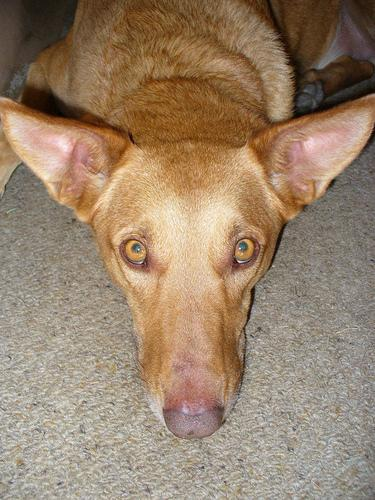

In [150]:
test_files = sorted(list(Path('/content/train/data/test').rglob('*.jpeg')))
image = Image.open(test_files[1])
image

In [151]:
def predict_one_sample(model, inputs):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        preds = logit.argmax(dim=1).item()

    return preds

In [152]:
final = pd.DataFrame(columns=['image_name', 'class'])
for i in test_files:
    row = dict()
    row['image_name'] = str(i).split('/')[-1]
    row['class'] = predict_one_sample(model, transform(Image.open(i)).unsqueeze(0))
    final = pd.concat([final, pd.DataFrame([row])])

final.to_csv('predictions.csv', index=False)

Выводы:

датасет довольно сложный, т.к. малое количество изображений, да и все собаки довольно похожи друг на друга. Можно было бы попробовать выучить свою модель, но тогда бы пришлось семплировать больше картинок - тем не менее, пополнять трейн дополнительными изображениями оказалось полезно.